In [ ]:
from tabula import convert_into

input_file = 'statement.pdf'
output = 'transactions.csv'
convert_into(input_file, output, output_format='csv', pages='all', stream=True)

print('The CSV file has been created')


Classify data into different transaction types 
Find the total amount of each transaction
Find the total amount spent
Visualize the data.

Individual Transaction Sums:
----------------------------------------
Send Money: KES 660.00
Buy Goods: KES 2,555.00
Transaction Cost: KES 28.00
Pochi La Biashara: KES 2,885.00
Paybill: KES 270.00
Airtime: KES 250.00
Withdrawal Cost: KES 87.00
Bundles Payment: KES 481.00
Card: KES 467.16
----------------------------------------
Total Withdrawn Across All Transactions: KES 7,683.16


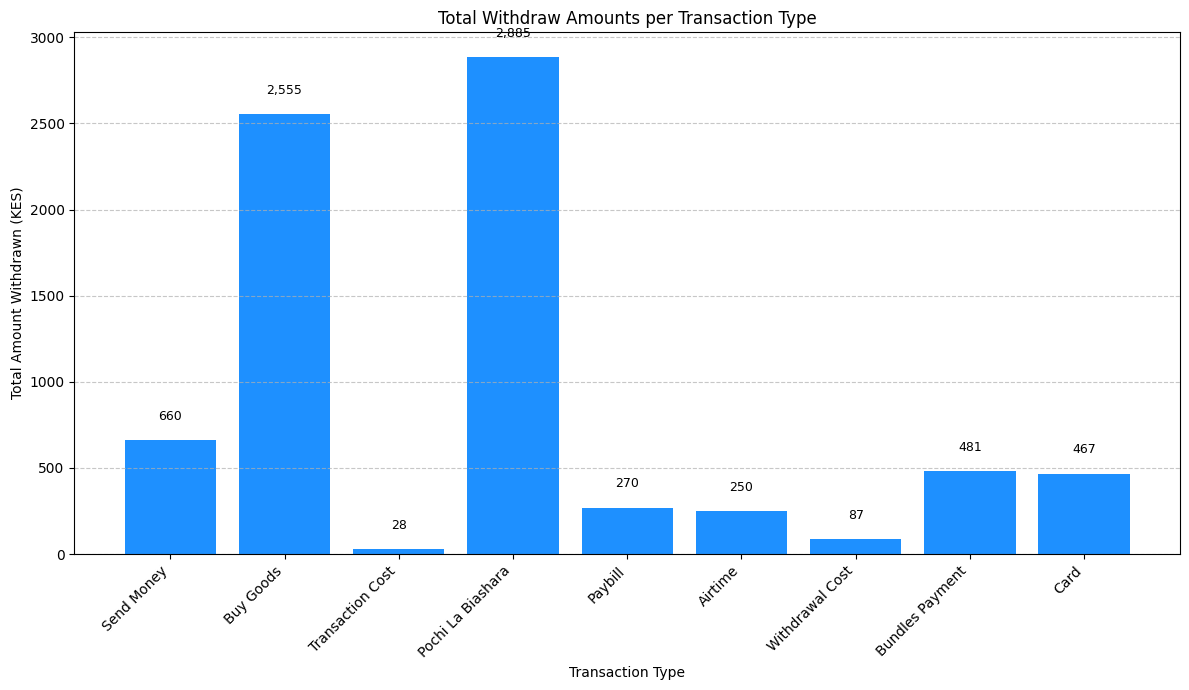

In [1]:
import csv
from collections import defaultdict
import re
import matplotlib.pyplot as plt


transaction_patterns = {
    'Send Money': re.compile(r'customer transfer to ', re.IGNORECASE),
    'Pochi La Biashara': re.compile(r'Customer Payment to Small Business to', re.IGNORECASE),
    'Paybill': re.compile(r'pay bill to ', re.IGNORECASE),
    'Airtime': re.compile(r'Airtime Purchase', re.IGNORECASE),
    'Buy Goods': re.compile(r'merchant payment ', re.IGNORECASE),
    'Transaction Cost': re.compile(r'customer transfer of funds charge', re.IGNORECASE),
    'Withdrawal Cost': re.compile(r'Withdrawal Charge', re.IGNORECASE),
    'Card': re.compile(r'card pay bill ', re.IGNORECASE),
    'Bundles Payment': re.compile(r'customer bundle purchase', re.IGNORECASE),
}

transactions_sum_by_type = defaultdict(float)


with open('transactions.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        details = row['Details']
        withdrawn_amount = row['Withdraw']

        try:
            withdrawn_amount = float(withdrawn_amount)
        except (ValueError, TypeError):
            withdrawn_amount = 0

        if withdrawn_amount > 0:
            matched = False
            for transaction_type, pattern in transaction_patterns.items():
                if pattern.search(details):
                    transactions_sum_by_type[transaction_type] += withdrawn_amount
                    matched = True
                    break
            


transaction_types = []
amounts = []

print("Individual Transaction Sums:")
print("-" * 40)
total_sum = 0

for transaction_type, total_amount in transactions_sum_by_type.items():
    print(f"{transaction_type}: KES {total_amount:,.2f}")
    transaction_types.append(transaction_type)
    amounts.append(total_amount)
    total_sum += total_amount

print("-" * 40)
print(f"Total Withdrawn Across All Transactions: KES {total_sum:,.2f}")


with open('transaction_summary.csv', mode='w', newline='') as csvfile:
    fieldnames = ['Transaction Type', 'Total Amount (KES)']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for t_type, amount in zip(transaction_types, amounts):
        writer.writerow({'Transaction Type': t_type, 'Total Amount (KES)': f"{amount:.2f}"})

# Plot
plt.figure(figsize=(12, 7))
bars = plt.bar(transaction_types, amounts, color='dodgerblue')
plt.xlabel('Transaction Type')
plt.ylabel('Total Amount Withdrawn (KES)')
plt.title('Total Withdraw Amounts per Transaction Type')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f'{yval:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Compare the amount spent in February to March
Visualise using a pie chart

Total Amount Spent:
------------------------------
February: KES 4,158.00
March:    KES 4,925.16


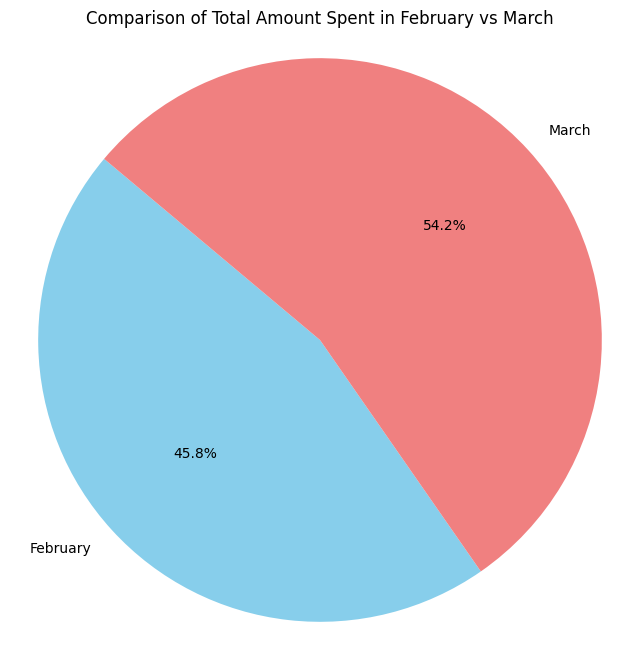

In [ ]:
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

amount_March = 0
amount_Feb = 0


with open('transactions.csv',newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        completion_time = row['Completion Time']
        withdrawn_amount = row['Withdraw']

        try:
            withdrawn_amount = float(withdrawn_amount)
        except (ValueError, TypeError):
            withdrawn_amount = 0

        if withdrawn_amount > 0 and completion_time:

            try:

                date_obj = datetime.strptime(completion_time,'%m/%d/%Y %H:%M')
                if date_obj.month == 2:
                    amount_Feb += withdrawn_amount
                elif date_obj.month == 3: 
                    amount_March += withdrawn_amount

            except (ValueError, TypeError):
                continue

print("Total Amount Spent:")
print("-" * 30)
print(f"February: KES {amount_Feb:,.2f}")
print(f"March:    KES {amount_March:,.2f}")

labels = ['February', 'March']
amounts = [amount_Feb, amount_March]
colors = ['skyblue', 'lightcoral']


plt.figure(figsize=(8, 8))
plt.pie(amounts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Comparison of Total Amount Spent in February vs March')
plt.axis('equal')  
plt.show()

        
        

In [27]:
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime
from collections import defaultdict

# Transaction type patterns
transaction_patterns = {
    "Send Money": r'^Customer Transfer to',
    "Pochi la Biashara": r'^Customer Payment to Small Business',
    "Till Numbers": r'^Merchant Payment',
    "Paybill Numbers": r'^Pay Bill',
    "M-Shwari Deposit": r'^M-Shwari Deposit',
    "Airtime Purchase": r'^Airtime Purchase',
    "Data Bundles": r'^Customer Bundle Purchase',
    "Transaction Cost": r'^Customer Transfer of Funds',
    "Agent Withdrawal": r'^Customer Withdrawal',
    "Withdrawal cost": r'^Withdrawal Charge',
    "Card": r'^Card Pay Bill',
}

# Prompt user for PDF inputs
pdf_files = input("Enter PDF file names separated by commas: ").split(',')

for pdf_path in map(str.strip, pdf_files):
    if not os.path.isfile(pdf_path):
        print(f"File not found: {pdf_path}")
        continue

    print(f"\nProcessing: {pdf_path}")
    transactions = []
    base_name = os.path.splitext(os.path.basename(pdf_path))[0]

    # Extract tables
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            table = page.extract_table()
            if table:
                headers = table[0]
                for row in table[1:]:
                    transactions.append(dict(zip(headers, row)))

    if not transactions:
        print(f"No data extracted from {pdf_path}")
        continue

    # Save raw transactions CSV
    raw_csv = f"{base_name}_transactions.csv"
    pd.DataFrame(transactions).to_csv(raw_csv, index=False)
    print(f"Saved: {raw_csv}")

    
    df = pd.read_csv(raw_csv)

    
    df.columns = [col.strip() for col in df.columns]
    df.rename(columns=lambda x: x.replace('\n', '').replace(' ', ''), inplace=True)
    
    # Clean and convert types
    for col in ['Paidin', 'Withdrawn', 'Balance']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(',', '', regex=False).astype(float).abs()

    df['CompletionTime'] = pd.to_datetime(df['CompletionTime'], errors='coerce')
    df = df.dropna(subset=['CompletionTime'])
    df['Month'] = df['CompletionTime'].dt.to_period('M').astype(str) 
    df['Date'] = df['CompletionTime'].dt.date
    df['Time'] = df['CompletionTime'].dt.time
    df['Month'] = df['CompletionTime'].dt.strftime('%B %Y')

    print("Months found in data:", df['Month'].unique())

    # Save cleaned data
    df.to_csv(raw_csv, index=False)

   
    if 'Withdrawn' in df.columns:
        monthly_summary = df.groupby('Month')['Withdrawn'].sum().reset_index()
        monthly_summary.columns = ['Month', 'Total Spent (KSHS)']
        monthly_summary['Total Spent (KSHS)'] = monthly_summary['Total Spent (KSHS)'].round(2)

        # Add total row
        total_spent = monthly_summary['Total Spent (KSHS)'].sum()
        total_row = pd.DataFrame([['TOTAL', total_spent]], columns=monthly_summary.columns)
        monthly_summary = pd.concat([monthly_summary, total_row], ignore_index=True)

        # Save monthly summary
        monthly_csv = f"{base_name}_monthly_summary.csv"
        monthly_summary.to_csv(monthly_csv, index=False)
        print(f"Saved: {monthly_csv}")

        # Pie chart
        monthly_for_chart = monthly_summary[monthly_summary['Month'] != 'TOTAL']
        plt.pie(monthly_for_chart['Total Spent (KSHS)'],
            labels=monthly_for_chart['Month'],
            autopct='%1.1f%%', startangle=140)
        plt.title(f"Monthly Withdrawals: {base_name}")
        pie_path = f"{base_name}_monthly_pie.png"
        plt.savefig(pie_path)
        plt.close()
        print(f"Saved pie chart: {pie_path}")

    
    category_totals = defaultdict(float)
    for category, pattern in transaction_patterns.items():
        matched = df['Details'].str.contains(pattern, na=False, case=False)
        if 'Withdrawn' in df.columns:
            category_totals[category] += df.loc[matched, 'Withdrawn'].sum()

    cat_df = pd.DataFrame(category_totals.items(), columns=["Transaction Type", "Amount (KSHS)"])
    cat_df["Amount (KSHS)"] = cat_df["Amount (KSHS)"].round(2)

    # Add total row
    cat_total = cat_df["Amount (KSHS)"].sum()
    cat_df = pd.concat([cat_df, pd.DataFrame([["TOTAL", cat_total]], columns=cat_df.columns)], ignore_index=True)

    # Save category summary
    category_csv = f"{base_name}_category_summary.csv"
    cat_df.to_csv(category_csv, index=False)
    print(f"Saved: {category_csv}")

    # Bar chart 
    cat_chart_df = cat_df[cat_df["Transaction Type"] != "TOTAL"]
    plt.figure(figsize=(10, 6))
    plt.bar(cat_chart_df["Transaction Type"], cat_chart_df["Amount (KSHS)"], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Amount (KSHS)")
    plt.title(f"Transaction Category Totals: {base_name}")
    plt.tight_layout()
    bar_path = f"{base_name}_category_bar.png"
    plt.savefig(bar_path)
    plt.close()
    print(f"Saved bar chart: {bar_path}")


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox



Processing: statement.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


Saved: statement_transactions.csv
Months found in data: ['March 2025' 'February 2025']
Saved: statement_monthly_summary.csv
Saved pie chart: statement_monthly_pie.png
Saved: statement_category_summary.csv


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


Saved bar chart: statement_category_bar.png

Processing: statement2.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


Saved: statement2_transactions.csv
Months found in data: ['March 2025' 'February 2025']
Saved: statement2_monthly_summary.csv
Saved pie chart: statement2_monthly_pie.png
Saved: statement2_category_summary.csv
Saved bar chart: statement2_category_bar.png
